- compare with MCMC: mean field approx. + runtime
- better plots --> mean field approximation
- natural covarying
- stretch goal: experiment with different distributions


# VI for Linear Regression Demo

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Generate a simple dataset

In [19]:
# Number of datapoints
n = 11

# evenly spaced features
x_train = torch.linspace(0,1,n)

# design matrix
Phi = torch.vstack((torch.ones(n),x_train)).T

# "true" parameter values
W_true = torch.ones(2,1)

# Observational noise
sigma2_obs = 1e-2

# Compute the true y and corrupt with noise
y_train = Phi @ W_true + torch.randn(n,1)*np.sqrt(sigma2_obs)

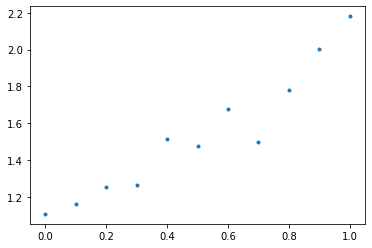

In [20]:
plt.plot(x_train,y_train,'.')

Next we need to specify prior distributions for model parameters.  Good choices would be mean zero with a large variance (i.e. a vague prior)

In [21]:
# Specify priors
mu_prior = torch.zeros(2,1)
sigma2_prior = torch.ones(2,1)
sigma2_prior.data[:]*=100.0

In [22]:
mu_prior

tensor([[0.],
        [0.]])

Next we'll initialize the parameters of our variational distribution.  We'll assume the mean-field approximation over both the slope and intercept with a normal variational posterior with learnable mean and standard deviation
$$
q(\mathbf{w}) = \mathcal{N}(w_0;\mu_0,\sigma_0) \mathcal{N}(w_1;\mu_1,\sigma_1).
$$
Note the parameterization in terms of std. dev. instead of variance.  This avoids having to explicitly constrain the variable to be positive.


In [23]:
mu_post = torch.rand(2,1,requires_grad=True)
sigma_post = torch.rand(2,1,requires_grad=True)

We will optimize the loss
$$
L = \frac{1}{m} \sum_{j=1}^m \log P(\mathbf{y}_{obs} | \mathbf{x}_{obs}, \mathbf{w}_j) + KL(q(\mathbf{w}) || p(\mathbf{w}) ),
$$
with $\mathbf{w}_j \sim q(\mathbf{w})$ and $p(\mathbf{w})$ the prior defined above.  Thus we need a log-likelihood and a function that computes the (analytical) KL distribution between two diagonal normals.  



In [24]:
def log_likelihood(y_pred,y_obs,sigma2_obs):
    return n/2*np.sqrt(2*np.pi*sigma2_obs) + 0.5/sigma2_obs*torch.sum((y_pred - y_obs)**2)

def kl_gaussian_diagonal(mu_post,mu_prior,sigma2_post,sigma2_prior):
    k = len(mu_post)
    log_det_ratio = torch.log(sigma2_prior).sum() - torch.log(sigma2_post).sum()
    sse = torch.sum((mu_post - mu_prior)**2/sigma2_prior)
    trace = (sigma2_post/sigma2_prior).sum()
    return 0.5*(log_det_ratio - k + sse + trace)

Now we can perform a training loop with simple stochastic gradient descent.

Text(0, 0.5, 'loss')

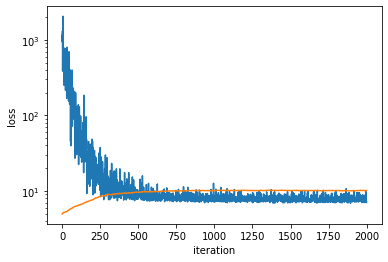

In [25]:
n_iterations = 2000

# Number of likelihood evaluations for MC-approximation to data loss
n_samples = 4

# step size (this is annoying to tune: better to use ADAM)
eta = 1e-5

data_losses = []
kl_losses = []

# training loop
for i in range(n_iterations):
  

    # Compute data loss
    L_data = 0
    for j in range(n_samples):
        # Sample parameters
        W = mu_post + torch.randn(2,1)*sigma_post
        
        # Compute forward model
        y_pred = Phi @ W
        
        # Update data loss
        L_data = L_data + log_likelihood(y_pred,y_train,sigma2_obs)/n_samples
    
    
    # Compute KL-loss (prior)
    L_kl = kl_gaussian_diagonal(mu_post,mu_prior,sigma_post**2,sigma2_prior)
    
    L = L_data + L_kl
    L.backward()
    
    data_losses.append(L_data.detach())
    kl_losses.append(L_kl.detach())
    
    # Gradient descent
    with torch.no_grad():
        mu_post -= eta*mu_post.grad
        sigma_post -= eta*sigma_post.grad
    mu_post.grad = None
    sigma_post.grad = None 
    
# Plot convergence 
plt.semilogy(data_losses)
plt.semilogy(kl_losses)
plt.xlabel('iteration')
plt.ylabel('loss')

Bayesian linear regression has an analytical solution for both posterior mean and (full) covariance matrix.  This is useful for comparison.  

In [26]:
# Posterior precision
Sigma_inv = 1./sigma2_obs*Phi.T @ Phi + torch.diag(1./sigma2_prior)

# Posterior covariance
Sigma = torch.linalg.inv(Sigma_inv)

# Posterior cholesky decomp (matrix square root)
L = torch.linalg.cholesky(Sigma)

# Posterior mean
mu_analytical = 1./sigma2_obs * Sigma @ Phi.T @ y_train

In [27]:
print(mu_post,sigma_post)

tensor([[1.0501],
        [0.9699]], requires_grad=True) tensor([[0.0300],
        [0.0502]], requires_grad=True)


We can visualize both the posterior predictive distribution (the set of lines that are consistent with the data) as well as the posterior distribution (the slope and intercept samples).

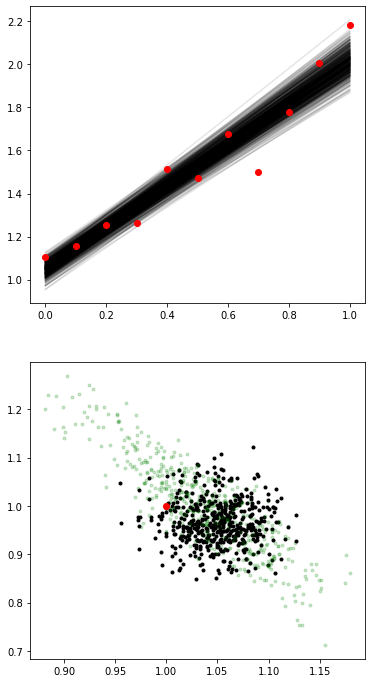

In [45]:
with torch.no_grad():
    # Number of posterior samples to draw
    n_plots = 500
    fig,axs = plt.subplots(nrows=2)
    w_0_samples = []
    w_1_samples = []
    for i in range(n_plots):
        # Random sample from variational posterior
        W = mu_post + torch.randn(2,1)*sigma_post
        y_pred = Phi @ W 
        # Plot predictive
        axs[0].plot(x_train,y_pred.detach(),'k-',alpha=0.1)
        # Plot parameters
        axs[1].plot(W[0],W[1],'k.')
        w_0_samples.append([W[0].item(),W[1].item()])
        # Bonus plot: samples drawn from the analytical posterior
        W_analytical = mu_analytical + L @ torch.randn(2,1)
        axs[1].plot(W_analytical[0],W_analytical[1],'g.',alpha=0.2)
        w_1_samples.append([W_analytical[0].item(),W_analytical[1].item()])
        
    # Plot data/true values
    axs[0].plot(x_train,y_train,'ro')
    axs[1].plot(W_true[0],W_true[1],'ro')
fig.set_size_inches(6,12)

In [29]:
w_0_samples = np.array(w_0_samples)
w_1_samples = np.array(w_1_samples)

In [30]:
import seaborn as sns
import pandas as pd

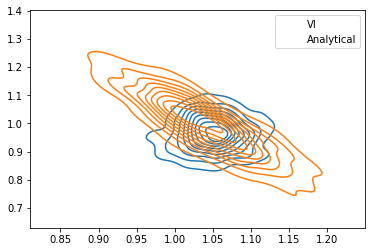

In [31]:
sns.kdeplot(x=w_0_samples[:,0], y=w_0_samples[:,1],label="VI")
sns.kdeplot(x=w_1_samples[:,0], y=w_1_samples[:,1],label="Analytical")
plt.legend()
plt.show()

In [25]:
w_0_samples[:,0].shape

(500,)

## Integrate MCMC functions

In [53]:
from utils import mcmc, mh

In [54]:
betas = mh(x_train, y_train, order=1, steps=10000)

/root/adML_VI/utils.py:28: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(design).T
/root/adML_VI/utils.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(design).T


Step 100/10000
Step 200/10000
Step 300/10000
Step 400/10000
Step 500/10000
Step 600/10000
Step 700/10000
Step 800/10000
Step 900/10000
Step 1000/10000
Step 1100/10000
Step 1200/10000
Step 1300/10000
Step 1400/10000
Step 1500/10000
Step 1600/10000
Step 1700/10000
Step 1800/10000
Step 1900/10000
Step 2000/10000
Step 2100/10000
Step 2200/10000
Step 2300/10000
Step 2400/10000
Step 2500/10000
Step 2600/10000
Step 2700/10000
Step 2800/10000
Step 2900/10000
Step 3000/10000
Step 3100/10000
Step 3200/10000
Step 3300/10000
Step 3400/10000
Step 3500/10000
Step 3600/10000
Step 3700/10000
Step 3800/10000
Step 3900/10000
Step 4000/10000
Step 4100/10000
Step 4200/10000
Step 4300/10000
Step 4400/10000
Step 4500/10000
Step 4600/10000
Step 4700/10000
Step 4800/10000
Step 4900/10000
Step 5000/10000
Step 5100/10000
Step 5200/10000
Step 5300/10000
Step 5400/10000
Step 5500/10000
Step 5600/10000
Step 5700/10000
Step 5800/10000
Step 5900/10000
Step 6000/10000
Step 6100/10000
Step 6200/10000
Step 6300/10000
S

In [55]:
coefs = mcmc(x_train, y_train, order=1)

Step 100/10000
Step 200/10000
Step 300/10000
Step 400/10000
Step 500/10000
Step 600/10000
Step 700/10000
Step 800/10000
Step 900/10000
Step 1000/10000
Step 1100/10000
Step 1200/10000
Step 1300/10000
Step 1400/10000
Step 1500/10000
Step 1600/10000
Step 1700/10000
Step 1800/10000
Step 1900/10000
Step 2000/10000
Step 2100/10000
Step 2200/10000
Step 2300/10000
Step 2400/10000
Step 2500/10000
Step 2600/10000
Step 2700/10000
Step 2800/10000
Step 2900/10000
Step 3000/10000
Step 3100/10000
Step 3200/10000
Step 3300/10000
Step 3400/10000
Step 3500/10000
Step 3600/10000
Step 3700/10000
Step 3800/10000
Step 3900/10000
Step 4000/10000
Step 4100/10000
Step 4200/10000
Step 4300/10000
Step 4400/10000
Step 4500/10000
Step 4600/10000
Step 4700/10000
Step 4800/10000
Step 4900/10000
Step 5000/10000
Step 5100/10000
Step 5200/10000
Step 5300/10000
Step 5400/10000
Step 5500/10000
Step 5600/10000
Step 5700/10000
Step 5800/10000
Step 5900/10000
Step 6000/10000
Step 6100/10000
Step 6200/10000
Step 6300/10000
S